# LZ Limit setting under different WIMP Halo assumptions
in this notebook we use https://arxiv.org/abs/2207.03764 and [`wimprates`](https://github.com/JelleAalbers/wimprates) to calculate no-background limits

In [1]:
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import wimprates
import os

import thesis_plots
from thesis_plots import mathrm
from thesis_plots.recoil_rates import nu, LimitSetter, LZ

# Make plots in preferred style using latex, but can safely be disabled
thesis_plots.setup_plt()
thesis_plots.print_versions(
    'thesis_plots wimprates'.split(),
    return_string=False,
    print_output=False,
    )

,module,version,path,git
0,python,3.10.4,/home/joran/yes/envs/py3.10/bin/python,None
1,thesis_plots,1.0.2,/home/joran/software/thesis_plots/thesis_plots,branch:more_datapoins | 1bba458
2,wimprates,0.4.1,/home/joran/software/wimprates_clean/wimprates,branch:fix_hardcoded_v0 | dc84cbd


# Set limits
For this we need two things:
 - a detector with some exposure, detector response (efficiency x ROI)
 - a model of the expected wimp rates

In [2]:
detector = LZ()
benchmark_model = dict(v_0=238*nu.km/nu.s, 
                       v_esc=544*nu.km/nu.s,
                       rho_dm=0.3* nu.GeV/nu.c0**2 / nu.cm**3
                      )
halo_model = thesis_plots.StandardHaloModelReadable(**benchmark_model)

In [3]:
limit_setter = LimitSetter(detector=detector, halo_model=halo_model)

we need the acceptance of signal as function of recoil energy to account for things like the energy threshold

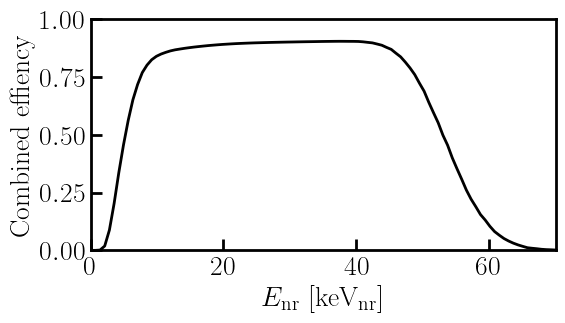

In [4]:
energy_kev = np.linspace(*detector.e_roi, 100)
plt.figure(figsize=(6,3))
plt.plot(energy_kev, detector.combined_efficiency(energy_kev), marker='')
plt.xlim(*detector.e_roi)
plt.ylim(0,1)
plt.xlabel('$E_\mathrm{nr}$ ' + mathrm('[keV_{nr}]'))
plt.ylabel(mathrm('Combined effiency'))
thesis_plots.save_fig('LZ_combined_efficiency')

To obtain the rates, we need some settings like which masses to compute. 

On github actions, we check that we can run this notebook, but that doesn't require spending a lot of time so we decrease our requirements then.


In [5]:
if os.environ.get('PLOT_FAST', False):
    mass_range = np.logspace(np.log10(5), np.log10(200), 5)
    limit_kw=dict(n_sigma_bins=5, log_sigma_range=(-48, -43))
else:
    # Normally, you run this, which takes about ~2.5 m/limit
    # If you want nice smooth plots, set n_sigma_bins to a large number, we use 
    # it to interpolate between to get the 90% conf. interval
    # n_masses dictates the number of mass-points to evaluate
    n_masses = 500
    n_sigma_bins = 200
    mass_range = np.logspace(np.log10(5), np.log10(1000), n_masses)
    limit_kw=dict(n_sigma_bins=n_sigma_bins, log_sigma_range=(-48, -44))

In [6]:
alt_v0 = thesis_plots.StandardHaloModelReadable(**dict(benchmark_model, **dict(v_0=220*nu.km/nu.s)))
alt_vesc = thesis_plots.StandardHaloModelReadable(**dict(benchmark_model, **dict(v_esc=528*nu.km/nu.s)))
alt_rho = thesis_plots.StandardHaloModelReadable(**dict(benchmark_model, **dict(rho_dm=0.4* nu.GeV/nu.c0**2 / nu.cm**3)))

def get_alt_limit(alt_model, _cache=True):
    """For a different halo model, get the approprate limit"""
    limit_hash = thesis_plots.deterministic_hash(
        {**limit_kw, 
         **alt_model.settings,
         **dict(w_version = thesis_plots.print_versions(['wimprates'], return_string=True, print_output=False,).split('\n')[-1])
        }
    )
    save_as = os.path.join(thesis_plots.root_folder, 'data', 'lz_limit', 'cached_sensitivities', 
                           f'sensitivity_{detector.__class__.__name__}_{alt_model.settings_name}_{limit_hash}.csv')
    if _cache and os.path.exists(save_as):
        return pd.read_csv(save_as)['sensitivity'].values
    limit_setter_alt = LimitSetter(detector=detector, halo_model=alt_model)
    limit = limit_setter_alt.set_limits(mass_range=mass_range,  **limit_kw, n_threads=25)
    if _cache:
        print(f'Saving {save_as}')
        pd.DataFrame(dict(wimp_mass = mass_range, sensitivity=limit)).to_csv(save_as)        
    return limit

In [7]:
# %%time
limit = get_alt_limit(halo_model)
limit_alt_v0 = get_alt_limit(alt_v0)
limit_alt_vesc = get_alt_limit(alt_vesc)
limit_alt_rho = get_alt_limit(alt_rho)

Getting limit for masses:   0%|          | 0/500 [00:00<?, ?it/s]

Saving /home/joran/software/thesis_plots/thesis_plots/../data/lz_limit/cached_sensitivities/sensitivity_LZ_v_0_238.0_v_esc_544.0_rho_dm_0.30_cpsnf6.csv


Getting limit for masses:   0%|          | 0/500 [00:00<?, ?it/s]

Saving /home/joran/software/thesis_plots/thesis_plots/../data/lz_limit/cached_sensitivities/sensitivity_LZ_v_0_220.0_v_esc_544.0_rho_dm_0.30_nzb7cz.csv


Getting limit for masses:   0%|          | 0/500 [00:00<?, ?it/s]

Saving /home/joran/software/thesis_plots/thesis_plots/../data/lz_limit/cached_sensitivities/sensitivity_LZ_v_0_238.0_v_esc_528.0_rho_dm_0.30_sk7p2i.csv


Getting limit for masses:   0%|          | 0/500 [00:00<?, ?it/s]

Saving /home/joran/software/thesis_plots/thesis_plots/../data/lz_limit/cached_sensitivities/sensitivity_LZ_v_0_238.0_v_esc_544.0_rho_dm_0.40_kbzvil.csv


Load the LZ limit from their released data as reference

In [8]:
lz_limit = pd.read_table(
    os.path.join(thesis_plots.root_folder, 'data', 'lz_limit', 'Fig5_SpinIndependentLimitandSensitivity.txt'),
    delimiter=' '
)

Plot the limit!

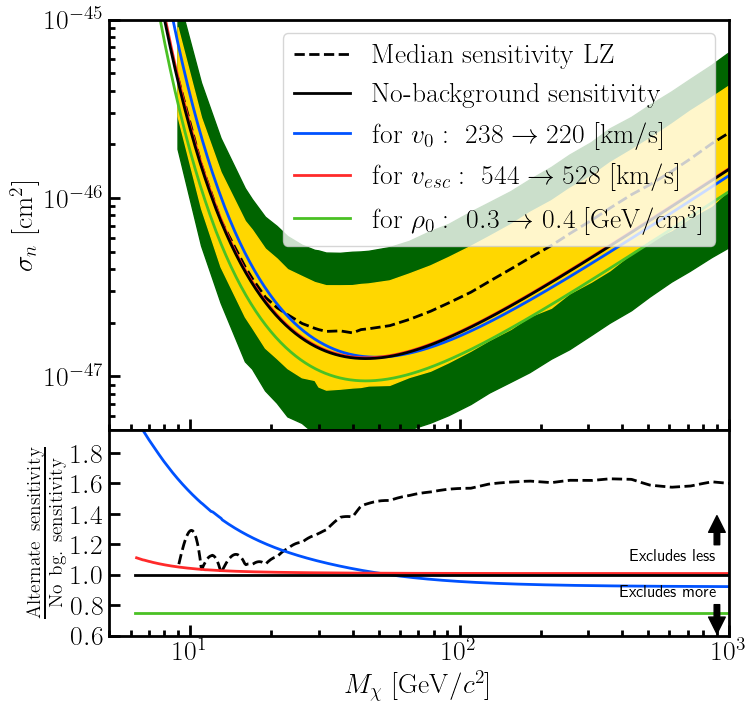

In [18]:
kw = dict(marker='')
_, axes = plt.subplots(
    2, 1, 
    sharex=True,
    figsize=(8,8),
    gridspec_kw={'height_ratios': [6, 3]})
plt.sca(axes[0])
# LZ lines
plt.plot(lz_limit['mass(GeV)'], lz_limit['median'], label=mathrm('Median sensitivity LZ'),  ls='--',  c='k', **kw,)
plt.fill_between(lz_limit['mass(GeV)'], lz_limit['-2sigma'], lz_limit['+2sigma'], color='darkgreen')
plt.fill_between(lz_limit['mass(GeV)'], lz_limit['-1sigma'], lz_limit['+1sigma'], color='gold')

# BG-free lines
plt.plot(mass_range, limit, label=mathrm('No') + '-' + mathrm('background sensitivity'), **kw, zorder=3)
plt.plot(mass_range, limit_alt_v0, label= mathrm('for ') + '$v_0:\ 238\\to220\ [\mathrm{km/s}]$', **kw,)
plt.plot(mass_range, limit_alt_vesc, label= mathrm('for ') +'$v_{esc}:\ 544\\to528\ [\mathrm{km/s}]$', **kw,)
plt.plot(mass_range, limit_alt_rho, label = mathrm('for ') +'$\\rho_0: \ 0.3\\to0.4\ [\mathrm{GeV/cm^3}]$', **kw,)

# Top panel settings
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$\sigma_n\ [\mathrm{cm}^2]$')
plt.legend(ncol=1, loc='upper right')
plt.ylim(5*10**-48, 10**-45)
# plt.ylim(10**-47, 3*10**-46)
plt.xlim(5, 1000)
plt.xscale('log')

# Bottom panel

plt.sca(axes[1])
# Skip the LZ sens
itp = scipy.interpolate.interp1d(lz_limit['mass(GeV)'], lz_limit['median'], bounds_error=False)
plt.plot(mass_range, itp(mass_range)/limit, **kw, c='k',ls='--')
plt.plot(mass_range, limit/limit, **kw, zorder=3)
plt.plot(mass_range, limit_alt_v0/limit,**kw)
plt.plot(mass_range, limit_alt_vesc/limit, **kw)
plt.plot(mass_range, limit_alt_rho/limit,**kw)

# settings
plt.ylabel('$\\frac{\\mathrm{Alternate\ sensitivity}}{\\mathrm{No\ bg.\ sensitivity}}$')
plt.xlabel('$M_\chi\ [\mathrm{GeV}/c^2]$')
plt.subplots_adjust(hspace=0.)
# plt.ylim(.5, 1.75)
plt.yticks([0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8           ])
#Save
plt.ylim(0.6, 1.95)
text_x = 900
plt.annotate('Excludes less', 
             xy=(text_x, 1.4),  
             xycoords='data',
             xytext=(text_x, 1.07), 
             textcoords='data',
             fontsize=12,
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='right', 
             verticalalignment='bottom',
            )
plt.annotate('Excludes more', 
             xy=(text_x, 0.6),  
             xycoords='data',
             xytext=(text_x, 0.93), 
             textcoords='data',
             fontsize=12,
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='right', 
             verticalalignment='top',
            )

thesis_plots.save_fig('limit_setting')

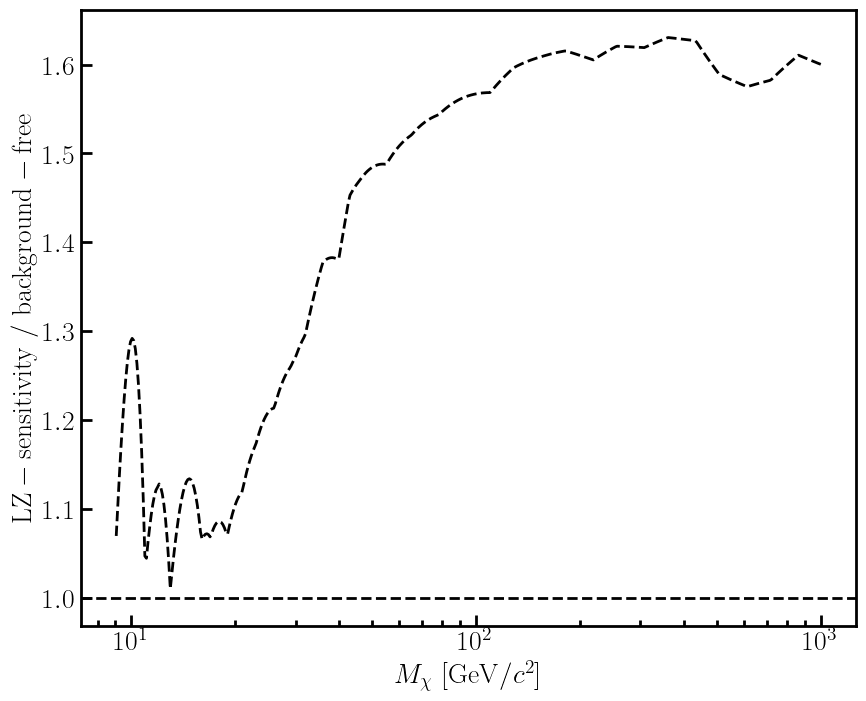

In [10]:
plt.axhline(1, ls='--', c='k')
itp = scipy.interpolate.interp1d(lz_limit['mass(GeV)'], lz_limit['median'], bounds_error=False)
plt.plot(mass_range, itp(mass_range)/limit, **kw, c='k',ls='--')
plt.ylabel(mathrm('LZ-sensitivity / background-free'))
plt.xlabel('$M_\chi\ [\mathrm{GeV}/c^2]$')
plt.xscale('log')